In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

import numpyro as npr
import numpyro.distributions as dist
from jax import random

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plots
plt.style.use('seaborn-whitegrid')

# PLOT PREAMBLE: LIKE LATEX
LATEX_WIDTH = 6
LATEX_HEIGHT = 3.24

SCRIPT_SIZE = 7

#Direct input
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : SCRIPT_SIZE,
          'axes.labelsize' : SCRIPT_SIZE,
          'xtick.labelsize' : SCRIPT_SIZE,
          'ytick.labelsize' : SCRIPT_SIZE,
          'legend.fontsize' : SCRIPT_SIZE,
          'figure.titlesize' : SCRIPT_SIZE,
          'font.family' : 'serif',
          'font.serif': ['Computer Modern Roman']
          }
plt.rcParams.update(params)

In [2]:
# Prior
def sample_prior(n_samples):
    rng_keys = random.split(random.PRNGKey(1), 2)
    mu = npr.sample('mu', dist.Normal(0, 1), sample_shape=(n_samples, 1), rng_key=rng_keys[0])
    sigma_sq = npr.sample('sigma_sq', dist.Gamma(1, 1), sample_shape=(n_samples, 1), rng_key=rng_keys[1])
    theta = np.concatenate((mu, sigma_sq), axis=-1)
    return theta

In [3]:
# Load data
thetas_prior = sample_prior(n_samples=10000)
thetas_approx = np.load(f'../res/abc/laplace_approx.npy').squeeze()

mu_true, sigma_sq_true = thetas_prior[:, 0], thetas_prior[:, 1]
mu_approx, sigma_sq_approx = thetas_approx[:, 0], thetas_approx[:, 1]

In [4]:
def fit_kde(ts, vals, kernel, bw, mirror=False):
    """Fit kernel density to data. If mirror=True, symmetrically extend the dataset around 0 to get the hard border at 0 right."""
    kde = KernelDensity(bandwidth=bw, kernel=kernel)
    if mirror==True:
        vals_extended = np.concatenate((-vals, vals))
        kde.fit(vals_extended[:, None])
        probs = 2 * np.exp(kde.score_samples(ts[:, None]))
    else:
        kde.fit(vals[:, None])
        probs = np.exp(kde.score_samples(ts[:, None]))
    return probs

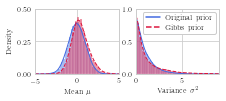

In [10]:
alpha_bins = .5
fig, axs = plt.subplots(ncols=2, figsize=(.55*LATEX_WIDTH, .2*LATEX_WIDTH))

bins_mu = np.linspace(-5, 5, 55)
sns.histplot(mu_true, ax=axs[0], label='Prior', color='royalblue', kde=False, stat='density', edgecolor="white", bins=bins_mu, alpha=alpha_bins)
sns.histplot(mu_approx, ax=axs[0], label='Gibbs prior', color='crimson', kde=False, stat='density', edgecolor="white", bins=bins_mu, alpha=alpha_bins)
axs[0].set_xlabel(r'Mean $\mu$')
axs[0].set_xlim((-5, 5))

bins_sigma_sq = np.linspace(0, 10, 55)
sns.histplot(sigma_sq_true, stat='density', ax=axs[1], label=r'Original prior', color='royalblue', kde=False, edgecolor="white", bins=bins_sigma_sq, alpha=alpha_bins)
sns.histplot(np.clip(sigma_sq_approx, a_min=0, a_max=10), stat='density', ax=axs[1], color='crimson',
             label=r'Gibbs prior', kde=False, edgecolor="white", bins=bins_sigma_sq, alpha=alpha_bins)


# Manually fit kernel density for sigma_sq, because Gaussian kernel is inappropriate for the hard boundary at 0
# mu
ts_mu = np.linspace(-5, 5, 500)
bw_mu = .25

prob_mu_true = fit_kde(ts_mu, mu_true, 'gaussian', bw_mu)
prob_mu_approx = fit_kde(ts_mu, mu_approx, 'gaussian', bw_mu)

axs[0].plot(ts_mu, prob_mu_true, color='royalblue', linewidth=1, linestyle='-')
axs[0].plot(ts_mu, prob_mu_approx, color='crimson', linewidth=1, linestyle='--')

# sigma_sq
ts_sigma_sq = np.linspace(0, 10, 500)
bw_sigma_sq = .2

prob_sigma_true = fit_kde(ts_sigma_sq, sigma_sq_true, 'gaussian', bw_sigma_sq, mirror=True)
prob_sigma_approx = fit_kde(ts_sigma_sq, sigma_sq_approx, 'gaussian', bw_sigma_sq, mirror=True)

axs[1].plot(ts_sigma_sq, prob_sigma_true, color='royalblue', linewidth=1, linestyle='-')
axs[1].plot(ts_sigma_sq, prob_sigma_approx, color='crimson', linewidth=1, linestyle='--')

# axs[1].legend()
axs[1].set_xlim([0, 9])

axs[1].set_xlabel(r'Variance $\sigma^2$')
axs[1].set_ylabel('')
# Ticks
# axs[0].set_yticks([0, 0.2, 0.5])
axs[0].set_yticks([0, 0.25, 0.5])
axs[0].set_ylim((0, 0.5))
axs[0].set_xticks([-5, 0, 5])
axs[1].set_yticks([0, 0.5, 1])
axs[1].set_xticks([0, 5])


handles = [Line2D([], [], label='Original prior', color='royalblue', linestyle='-'),
           Line2D([], [], label='Gibbs prior', color='crimson', linestyle='--')]

plt.legend(handles=handles, framealpha=1, frameon=True)
# plt.tight_layout()
# tikzplotlib.save('../fig/prior_vs_laplace.tex')
plt.savefig('../fig/prior_vs_laplace.pdf', bbox_inches='tight')
plt.show()

# Stochastic monotonicity

In [5]:
def position_in_sorted(t, sorted_vec):
    """Position of value t in the sorted vector sorted_list."""
    pos = 0
    for i in range(len(sorted_vec)):
        if t <= sorted_vec[i]:
            break
        else:
            pos += 1
    return pos

def get_cdf_val(t, sorted_vec):
    return position_in_sorted(t, sorted_vec) / len(sorted_vec)

In [6]:
mu_true_sorted, sigma_sq_true_sorted = np.sort(thetas_prior[:, 0]), np.sort(thetas_prior[:, 1])
mu_approx_sorted, sigma_sq_approx_sorted = np.sort(thetas_approx[:, 0]), np.sort(thetas_approx[:, 1])

ts_mu = np.linspace(-5, 5, 500)
ts_sigma_sq = np.linspace(0, 9, 500)

mu_true_cdf = [get_cdf_val(t, mu_true_sorted) for t in ts_mu]
mu_approx_cdf = [get_cdf_val(t, mu_approx_sorted) for t in ts_mu]
sigma_sq_true_cdf = [get_cdf_val(t, sigma_sq_true_sorted) for t in ts_sigma_sq]
sigma_sq_approx_cdf = [get_cdf_val(t, sigma_sq_approx_sorted) for t in ts_sigma_sq]

In [7]:
sigma_sq_maks = [sigma_sq_true_cdf[i] >= sigma_sq_approx_cdf[i] for i in range(len(ts_sigma_sq))]
t_equal_cdf = np.round(ts_sigma_sq[sigma_sq_maks][1], 2)
t_val_equal_cdf = np.round(np.array(sigma_sq_true_cdf)[sigma_sq_maks][1], 2)
print(f'The cdfs for the variance coincide at t={np.round(t_equal_cdf, 2)} with a value of F(t)={np.round(t_val_equal_cdf, 2)}')

The cdfs for the variance coincide at t=0.02 with a value of F(t)=0.02


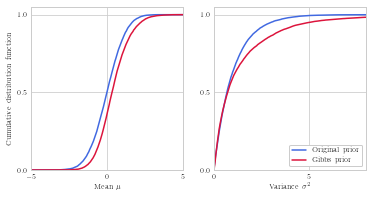

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(LATEX_WIDTH, .5*LATEX_WIDTH))

# Means cdf
axs[0].plot(ts_mu, mu_true_cdf, label='Original prior', color='royalblue')
axs[0].plot(ts_mu, mu_approx_cdf, label='Gibbs prior', color='crimson')

axs[0].set_xlabel(r'Mean $\mu$')
axs[0].set_ylabel(r'Cumulative distribution function')

# Variances cdf
axs[1].plot(ts_sigma_sq, sigma_sq_true_cdf, label='Original prior', color='royalblue')
axs[1].plot(ts_sigma_sq, sigma_sq_approx_cdf, label='Gibbs prior', color='crimson')

axs[1].set_xlabel(r'Variance $\sigma^2$')
axs[1].set_ylabel('')

axs[0].set_xlim((-5, 5))
axs[1].set_xlim((0, 8))
axs[0].set_ylim((0, 1.05))
axs[1].set_ylim((0, 1.05))

axs[0].set_yticks([0, .5, 1])
axs[0].set_xticks([-5, 0, 5])
axs[1].set_yticks([0, .5, 1])
axs[1].set_xticks([0, 5])

plt.legend(framealpha=1, frameon=True, loc='lower right')
# plt.tight_layout()
# tikzplotlib.save('../fig/prior_vs_laplace_cdf.tex')
plt.savefig('../fig/prior_vs_laplace_cdf.pdf', bbox_inches='tight')
plt.show()